# Song lyrics analysis with text mining and songs recommendation

This notebook is split in two parts, at the beginning I analyze the song lyrics and the genres using some text mining techniques in order to explore the data.

In the last section of the notebook I built a simple songs recommendation system that returns the most similar songs related to a given one. I used an evaluation dataset in order to evaluate numerically the suggestions of the system and I computed the mAP on these songs.

First of all we need to download and import the needed libraries.

In [1]:
# Install and import the needed libraries
install.packages("lsa", quiet=T)
install.packages("tm", quiet=T)
install.packages("googledrive", quiet=T)

library("tm")
library("lsa")
library("googledrive")

also installing the dependency ‘SnowballC’


also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’


Loading required package: NLP

Loading required package: SnowballC



## Download the files and load the data

Then we download the dataset from Drive and we load to a dataframe in order to use the data for our analysis.

In [2]:
# Download the file from Drive
url_dataset <- "https://drive.google.com/file/d/1--Bg1EDkCTyRCSSLUX51oioUhbSg9gch/view?usp=share_link"
url_evaluation <- "https://drive.google.com/file/d/1kiR-P5fJCfNbqtlgHSMvGzFllDGs1tyU/view?usp=share_link"

drive_deauth()
dl_data <- drive_download(as_id(url_dataset), overwrite=TRUE)
dl_eval <- drive_download(as_id(url_evaluation), overwrite=TRUE)

File downloaded:

• songs_data.csv <id: 1--Bg1EDkCTyRCSSLUX51oioUhbSg9gch>

Saved locally as:

• songs_data.csv

File downloaded:

• eval_similar_songs.csv <id: 1kiR-P5fJCfNbqtlgHSMvGzFllDGs1tyU>

Saved locally as:

• eval_similar_songs.csv



In [3]:
cat("Loading the dataset csv into a dataframe...")
songs_df <- read.csv(dl_data$local_path)
cat("\nThe dataframe is ready!")

Loading the dataset csv into a dataframe...
The dataframe is ready!

As you can see in the following cell, the dataset has 5 columns, the track id, the title, the artist name, the stemmed lyrics (in BOW version) and the tag (genre) for each song.

In [4]:
head(songs_df, n=2)

,track_id,title,artist_name,lyrics,tag
,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAAABD128F429CF47,Soul Deep,The Box Tops,i i i i i i i i i i you you you you you you you you you you you you you you you you you to to to to to to to to and and a a me it it it not not in in in my my my my is is is your your your your your your your that that that that that do do do do do are are are are are are for for for for no have have have have have have so so know know know know know but but but what what what when when time time time can there there there there there la la la la la la la get get got got got never never feel feel want want would would day day day day away away yeah yeah yeah yeah heart heart heart heart heart could could need need need our our look look where where thing thing think live onli onli tri keep keep keep dream dream wanna wanna wanna find find find hear believ everyth everyth someth someth someth someth insid insid chang chang soul soul soul soul soul soul soul new start start pleas pleas true while while deep deep deep deep beat after after fade fade wast wast wast trust alreadi alreadi style style asleep wors wors goal goal,60s
2,TRAAAED128E0783FAB,It's About Time,Jamie Cullum,i i i i i i i i i i i i i i i i i i i i i i i i i i i i the the the the the the the the the the the the the the the you you to to to to to to to to to to to to and and and and and and and and and and and and and and and and and and and and and and a a me me it it it it not not in my my my my my my my my my my my my my my my my my my my my is is is of that that that that that that that do do on are are am am am am am am am am will will will will will will will will will will will will will for for for for for for be be be be have have have love love love love love love love love love love love so so so so so so so so so this this this this but just when when when like time time time time time time come come come come go one one one one out out down if if got got got got got got got from feel feel make make make make make make make make make make way way way way way way way way way take take take take take day day day by her her her her her her heart heart heart could look look look where more more more more more more more been been who who who who through through through through through through onli onli onli tri tri tri tri tri whi dream dream dream well an an an an an an long girl girl girl find find find find find find find find good about about about about about about some some some some some some some some littl wait run walk walk gone someth befor much much much much much much anoth new tonight tonight tonight burn thought realli hard care put seem mine mine mine mine fire someon someon someon someon while doe smile open open open open open open door door door door door door door mayb mayb mayb may may sometim lone lone lone chanc chanc chanc air water readi readi readi readi past happen pretti differ faith search flame piec cos cos cos meant higher edg surpris person twice noon thin celebr celebr celebr inspir advic ideal,jazz


At this point you can import from Drive also the term-document matrix computed on the 'lyrics' feature to avoid re-running again the code.

In [5]:
#@title #### Download from drive the table
#@markdown To avoid running the cell for creating the term-document matrix you can
#@markdown import the pre-saved table and load it in the variable 'tdm'.

library("data.table")

# Download the terms documents table from Drive
url_tdtable <- "https://drive.google.com/file/d/1ZLssnAWcrT77PreJh_mDnn4B6bpsq1JO/view?usp=share_link"
drive_deauth()
dl_table <- drive_download(as_id(url_tdtable), overwrite=TRUE)

# Load of the terms docs matrix 
cat("Loading the term-document matrix ...\n")
tdm <- as.matrix(fread(file=dl_table$local_path, header=FALSE))

# Extract list of words and set as rownames
words <- strsplit(tdm[, 1], " ")
rownames(tdm) <- words 

# Delete the column with the words and set colnames
tdm <- tdm[, -1]
colnames(tdm) <- 1:ncol(tdm)

# Convert the values to numbers, because importing from table they are characters
class(tdm) <- "numeric"

cat("\nIn the table there are", length(words), "words and", ncol(tdm), "songs.")

File downloaded:

• tdm.table <id: 1ZLssnAWcrT77PreJh_mDnn4B6bpsq1JO>

Saved locally as:

• tdm.table



Loading the term-document matrix ...

In the table there are 511 words and 151109 songs.

Otherwise you can execute the next cells in order to compute the term-document matrix from scratch.

### Create the term-document matrix

In [ ]:
# Save in the vector the lyrics of each song
song_lyrics = songs_df$lyrics

In the next cell the following steps will be executed:
1. load the lyrics in a Corpus object;
2. remove the english stop words;
3. create a term-document matrix;
4. eliminate the sparse terms from the matrix;
5. convert to a matrix R object.

You don't need to remove the punctuation or to make the test lowercase because the lyrics are already normalized in this way.

In [ ]:
# This creates the corpus dataset  
cat("- Creating the corpus dataset ...")
corpus <- Corpus(VectorSource(song_lyrics))

# With tm_map() we normalize our text set, firstly tolower case
#corpus <- tm_map( corpus, tolower ) 
# Then we remove the puntuactions 
#corpus <- tm_map( corpus, removePunctuation ) 

# Remove the stop words from a stoplist 
cat("\n- Removing the stop words ...")
corpus <- tm_map(corpus, removeWords, c(stopwords("english")))

# Now we can create the term-dcoument matrix
cat("\n- Creating the term-document matrix ...")
tdmc <- TermDocumentMatrix(corpus)

# Let's inspect the matrix
inspect(tdmc)

# We eliminate the terms with a frequency in documents lower than 2% 
cat("\n- Removing terms with a low frequency ...")
tdms <- removeSparseTerms(tdmc, 0.98) 
# Note: in LSA it is required that each term appears at least in 2 documents 
# after the elimination the terms are less than before, so we save the actually used words  
words <- rownames(tdms) 

inspect(tdms)

# To use the next functions we need to convert the sparse tdms to a standard R matrix  
cat("\n- Convert to a matrix ...")
tdm <- as.matrix(tdms)

In [ ]:
cat("The new matrix dimensions:", nrow(tdm), "x", ncol(tdm))

The new matrix dimensions: 511 x 151109

In [ ]:
# Write the term-document matrix in a table to read in some next runs
write.table(tdm, file="tdm.table", append=FALSE, row.names=TRUE, col.names=TRUE)

## Compute LSA on the TF-IDF matrix and visually analyze the data

In [6]:
# Application of the term weighting TF-IDF to the terms-docs matrix
tdmle <- lw_logtf(tdm) * (1-entropy(tdm))  
head(tdmle)

,1,2,3,4,5,6,7,8,9,10,⋯,151100,151101,151102,151103,151104,151105,151106,151107,151108,151109
away,0.1914003,0.0000000,0.0000000,0.2803964,0,0.0000000,0.0000000,0.2415203,0.1207601,0,⋯,0.1207601,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,0.2415203,0.0000000
beat,0.2057104,0.0000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.2057104,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000
believ,0.1620830,0.0000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0.0000000,0,⋯,0.0000000,0.1620830,0.0000000,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000
can,0.0903582,0.0000000,0.0903582,0.0000000,0,0.1807164,0.0903582,0.0000000,0.0000000,0,⋯,0.0000000,0.1807164,0.0000000,0.0000000,0.0903582,0,0.0903582,0,0.0000000,0.0000000
chang,0.2568937,0.0000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.0000000
day,0.2583091,0.2224954,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.0000000,0.1112477,0.0000000,0,0.0000000,0,0.0000000,0.1763234


In [7]:
# With this function we compute the norm of a vector
norm_vec <- function(x) sqrt(sum(x^2))

# We can compute the norm of each term in the terms-docs matrix
norm_terms <- apply(tdmle, 1, norm_vec)

# LSA space creation with rank automatically choosen by R
lsar <- lsa(tdmle) 

cat("The number of computed eigenvalues is", length(lsar$sk))

The number of computed eigenvalues is 209

You can see from the following chart that the difference in magnitude between the first eigenvalues is larger than the distances starting from the fifth onwards.

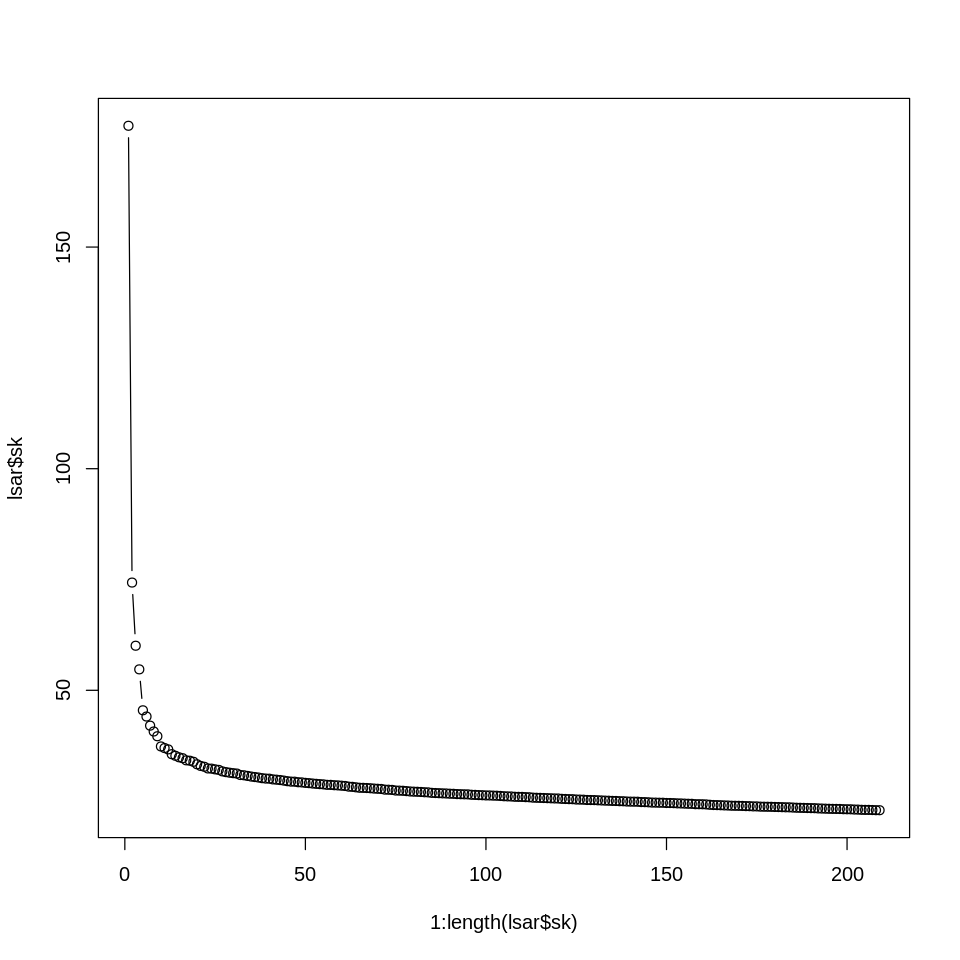

In [8]:
options(repr.plot.width=8, repr.plot.height=8)
plot(1:length(lsar$sk), lsar$sk, type="b")

All operations performed in the latent semantic space have to consider the different relevance of each column, therefore I computed the terms and the documents matrices re-weighting by the eigenvalues.

In [9]:
# Let's compute the two matrices of terms and docs, weighted by the eigenvalues
tls <- lsar$tk %*% diag(lsar$sk)
dls <- lsar$dk %*% diag(lsar$sk)

Given that the norm of each term represents the importance of that word in the latent space, I computed the norms of all terms and I added it as a column to the terms matrix. In this way I will be able to use this information in some future operations.

TODO: ricorda che tk era ortonormale ma dopo averla moltiplicata per gli autovalori non lo è più.

In [10]:
# Compute the norm for each term
norm_terms_lsa <- apply(tls, 1, norm_vec)

# Add the column of the norms to the matrix tls
tls_norm_terms = cbind(tls, norm_terms_lsa)

We can explore the top words in terms of norm and you can see that among the most relevant, there are some words in a language different from english, that's because we have a lot of english songs and few songs of other countries.

In [ ]:
cat("The norm of the word 'pour' is", norm_terms_lsa['pour'])
cat("\nThe norm of the word 'que' is", norm_terms_lsa['que'])

The norm of the word 'pour' is 20.37315
The norm of the word 'que' is 51.51338

In [11]:
sorted_norms <- sort(norm_terms_lsa, decreasing=T)
cat("The terms with the highest norm are:\n")
cat(paste(names(sorted_norms[1:15]), unname(sorted_norms[1:15]), sep=':', collapse="\n"))

The terms with the highest norm are:
que:51.5133837481065
love:46.0909707850539
babi:44.516782997032
yeah:43.3689919333297
get:39.4707625014346
wanna:39.0199343659272
gonna:38.7157121693732
got:38.6450485814649
hey:38.1013410375951
let:37.8729172425028
want:37.6419097930347
girl:37.3716401453211
come:36.1592235687824
like:35.5795258667823
die:35.3711722655785

As seen before, the first eigenvalues are the ones with the highest values, let's try to plot the words considering the first two latent dimensions. 

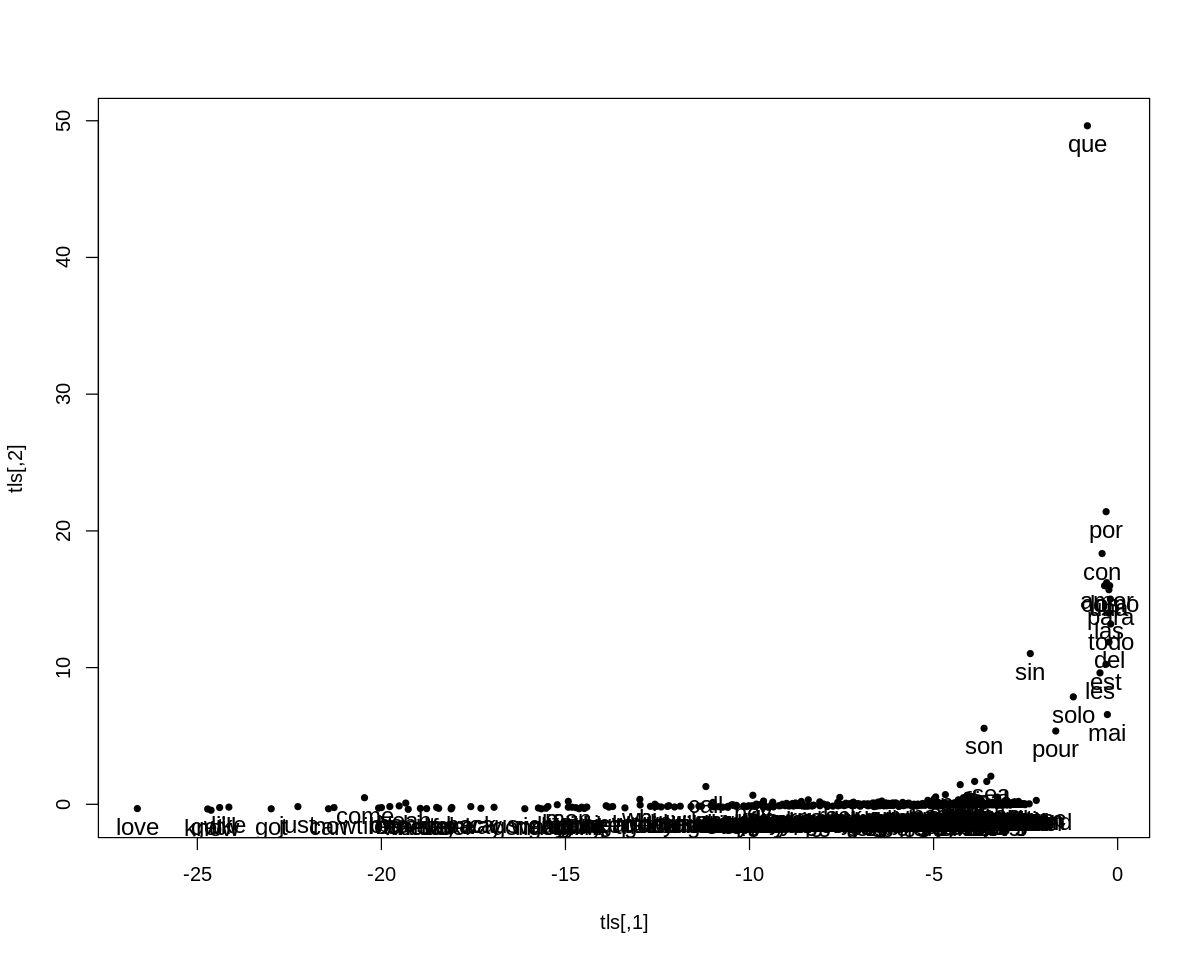

In [ ]:
# Graphic representation of terms using the first two latent dimensions
options(repr.plot.width=10, repr.plot.height=8)
plot(tls, pch=20)
text(tls, labels=words, cex=1.2, pos=1)

We have a lot of words close to the origin, thus they don't contain relevant information. The first latent dimension, with the corresponding eigenvalue, dominates the second dimension, that's why we have a compressed space along one dimension. 

Moreover let's try to remove some terms to have a clearer graph, selecting only the terms with a norm higher than a given threshold.

In [12]:
# We added one column at the end so we take length + 1
last_col <- length(lsar$sk)+1

# Computing the mean of the norm for the terms in order to set a suitable threshold
cat("The mean for the norm of the terms is", mean(tls_norm_terms[,last_col]))

The mean for the norm of the terms is 16.9056

In [13]:
# Subset of terms with norm > 17 (the last column contains the norms)
tls_reduced <- subset(tls_norm_terms, norm_terms_lsa > 17.0)[,-last_col]

cat("After the reduction we have", nrow(tls_reduced), "words.")

After the reduction we have 229 words.

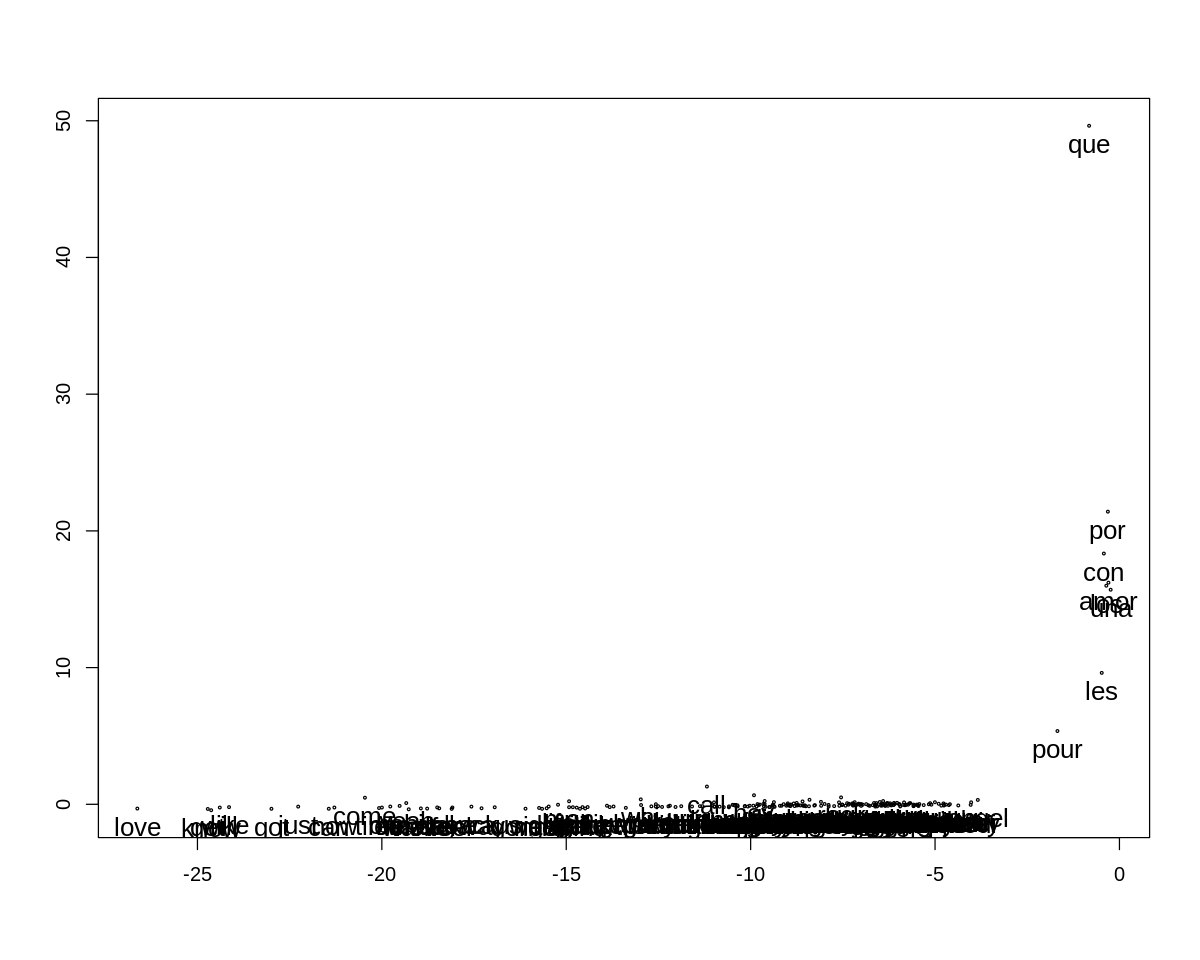

In [ ]:
# Representation of this terms subset using the first two latent dimensions
options(repr.plot.width=10, repr.plot.height=8)
plot(tls_reduced, pch=21, cex=0.3)
# Change the rownames otherwise mislabeled
text(tls_reduced, labels=rownames(tls_reduced), cex=1.3, pos=1)

I also plot the documents to check the distribution of them and it's similar to the one of the terms. 

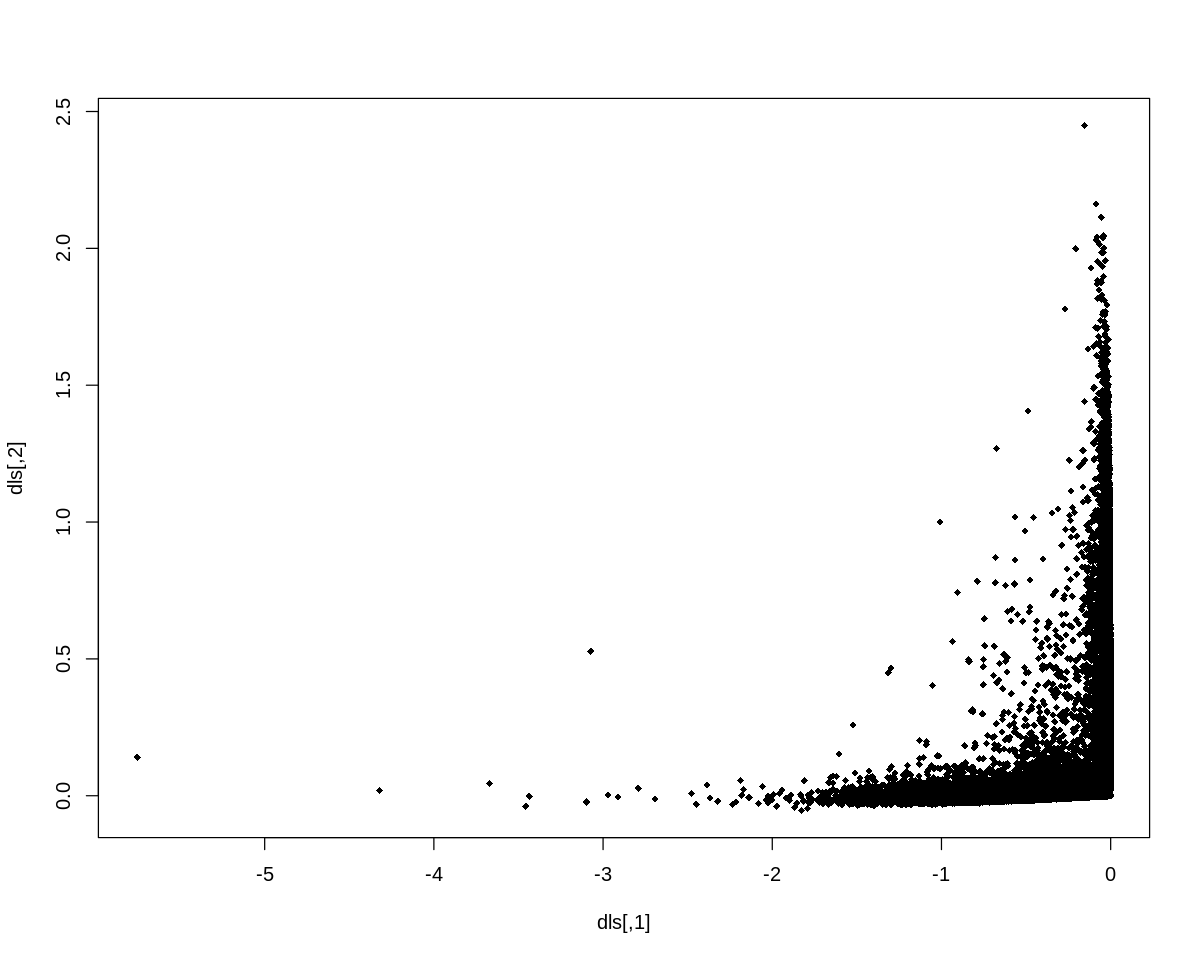

In [ ]:
# Graph of the documents using the first two latent dimensions
plot(dls, pch=18, cex=0.8)

We have the same problem, the documents are compressed in a narrow space and the majority of data is following a specific direction and it's within an area. We need that documents and words are as distributed as possible, radially from the origin. In cosine similarity, this alignment means that we are finding correlations and the elements are correlated with each other.

Let's try to display the elements with the second and third latent dimensions, the distance between these 2 eigenvalues is lower than the one between the first and the second eigenvalues.

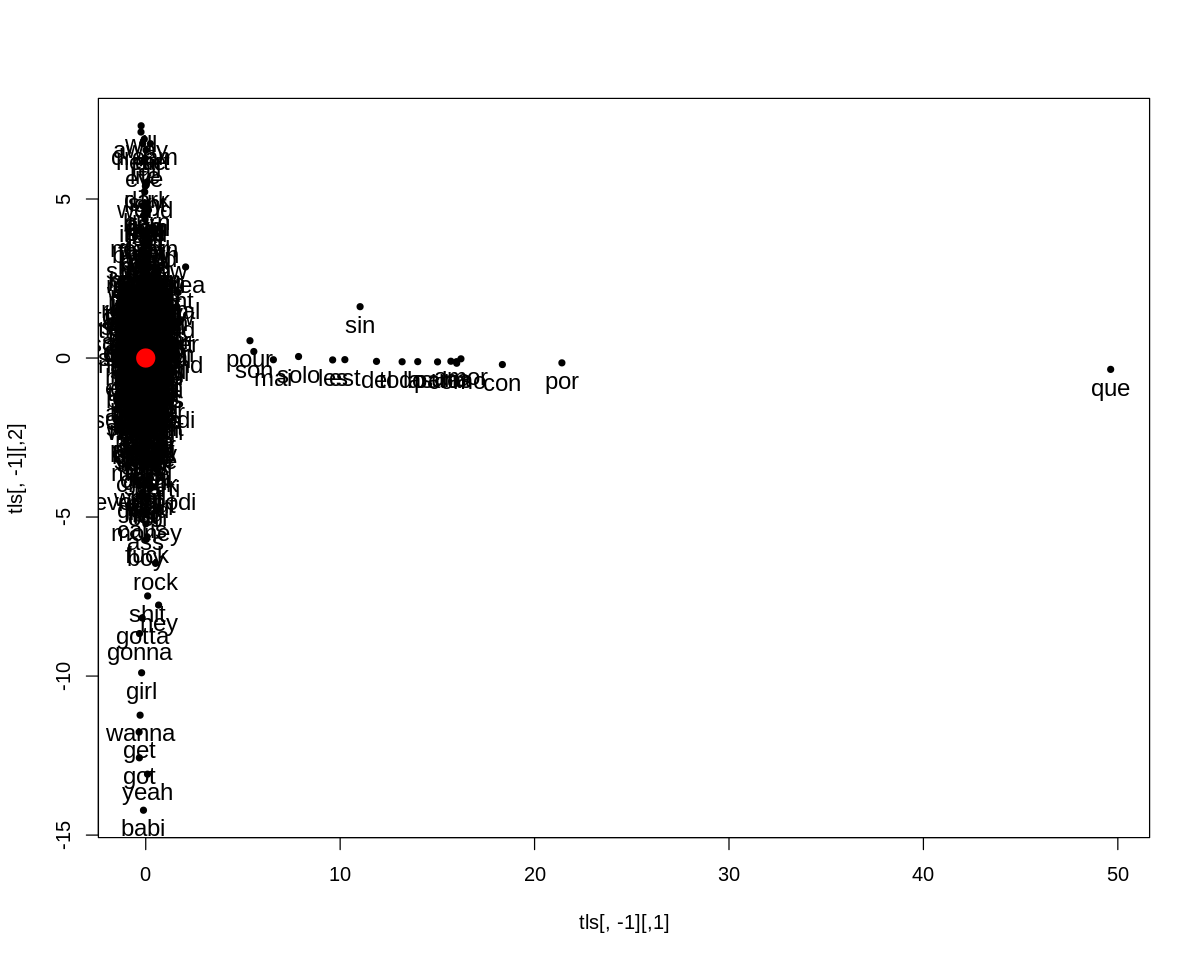

In [ ]:
# Graph representation of the terms using the second and third latent variables
options(repr.plot.width=10, repr.plot.height=8)

# -1 removes the first latent dimensions in order to display 2° and 3°
plot(tls[,-1], pch=20) 
text(tls[,-1], labels=words, cex=1.2, pos=1)

# Draw the origin 0,0 of the cartesian plane
points(0, 0, pch=20, cex=3, col="red")

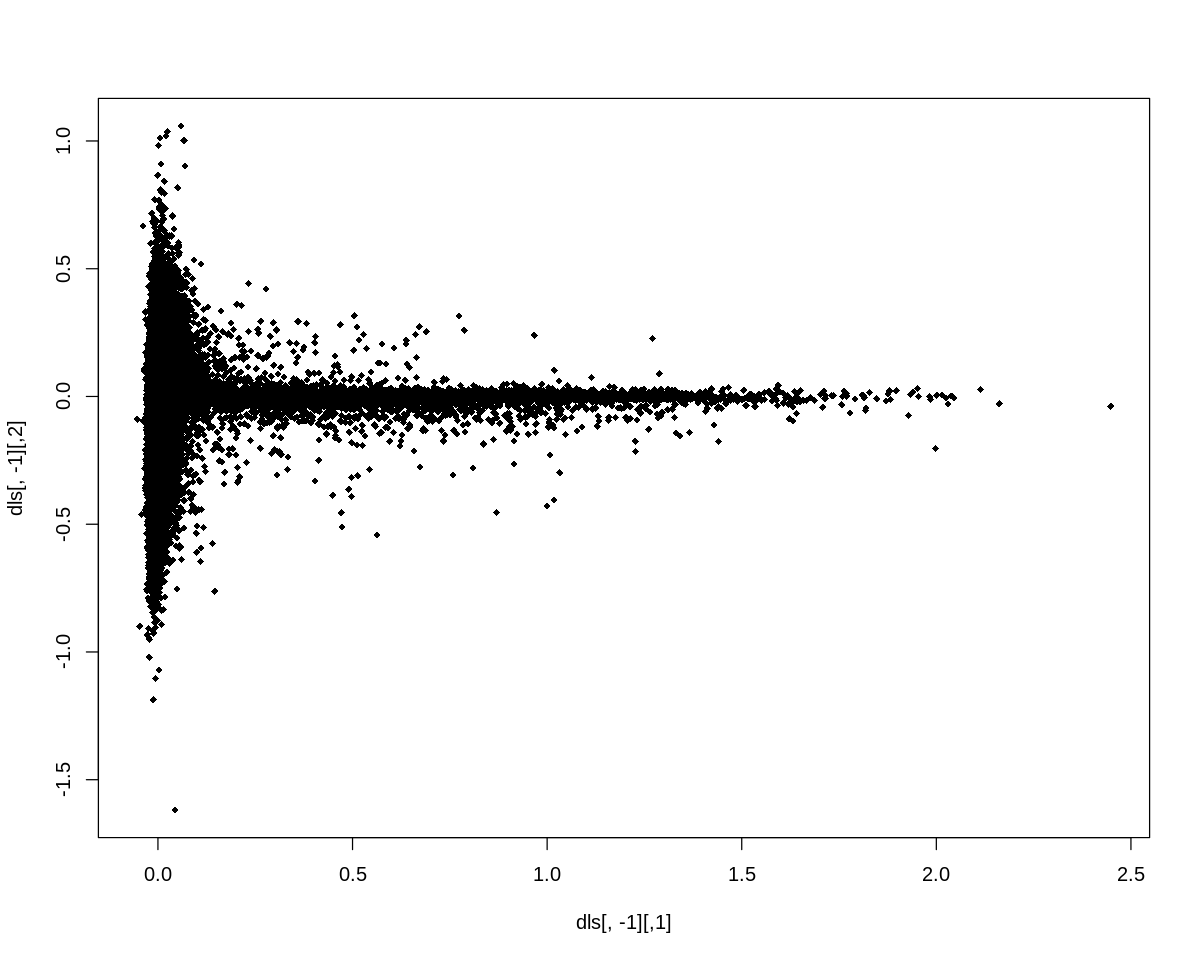

In [ ]:
# Graph of docs using 2° and 3° latent dimensions
plot(dls[,-1], pch=18, cex=0.8)

Now the words and documents are more distributed in several directions, because the values of the considered eigenvalues are more similar and therefore neither dimension compresses the other.

Let's try to plot also the third and fourth latent dimensions to confirm the previous idea.

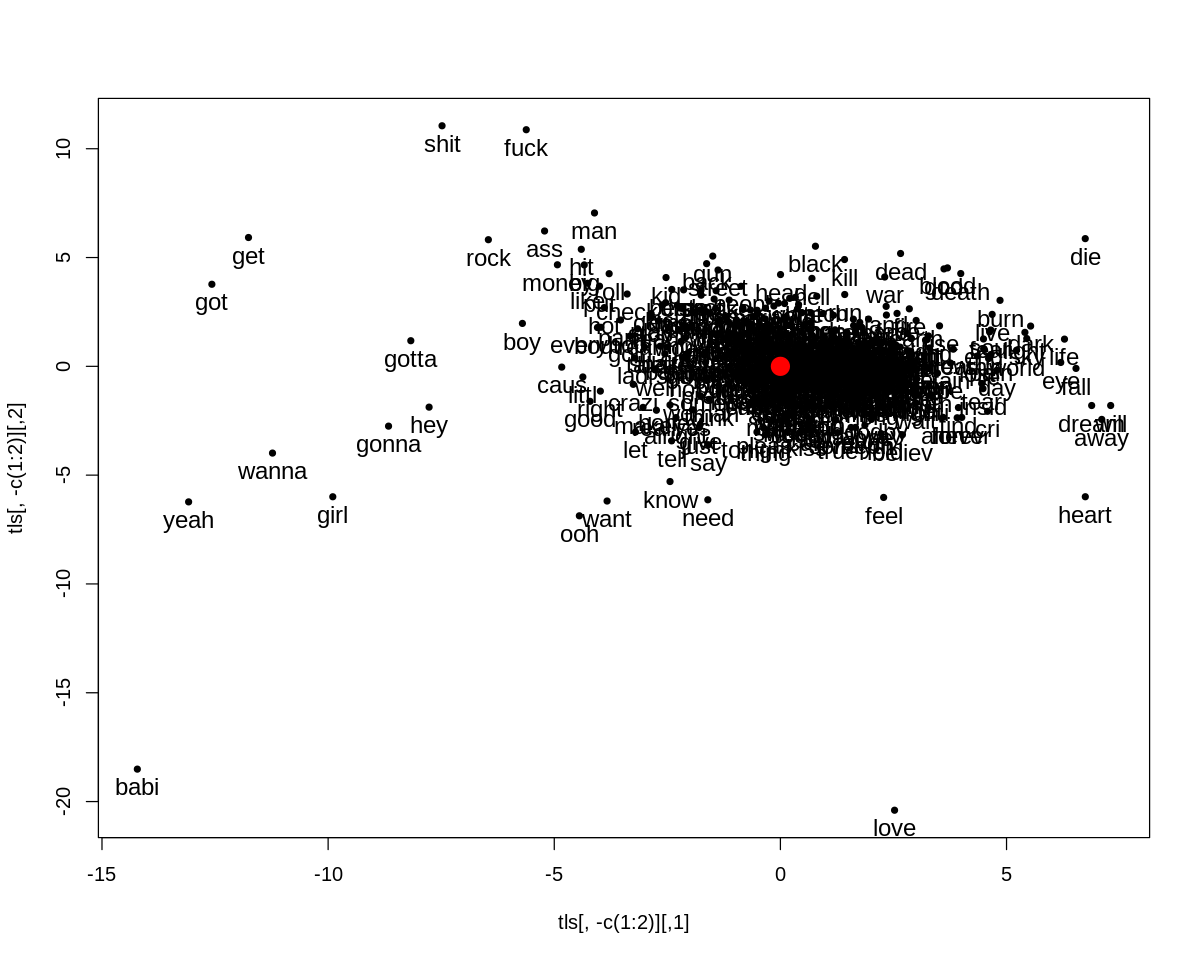

In [ ]:
# Graph representation of the terms using the third and fourth latent variables
options(repr.plot.width=10, repr.plot.height=8)

# -c(1:2) removes the first latent dimensions in order to display 3° and 4°
plot(tls[,-c(1:2)], pch=20) 
text(tls[,-c(1:2)], labels=words, cex=1.2, pos=1)

# Draw the origin 0,0 of the cartesian plane
points(0, 0, pch=20, cex=3, col="red")

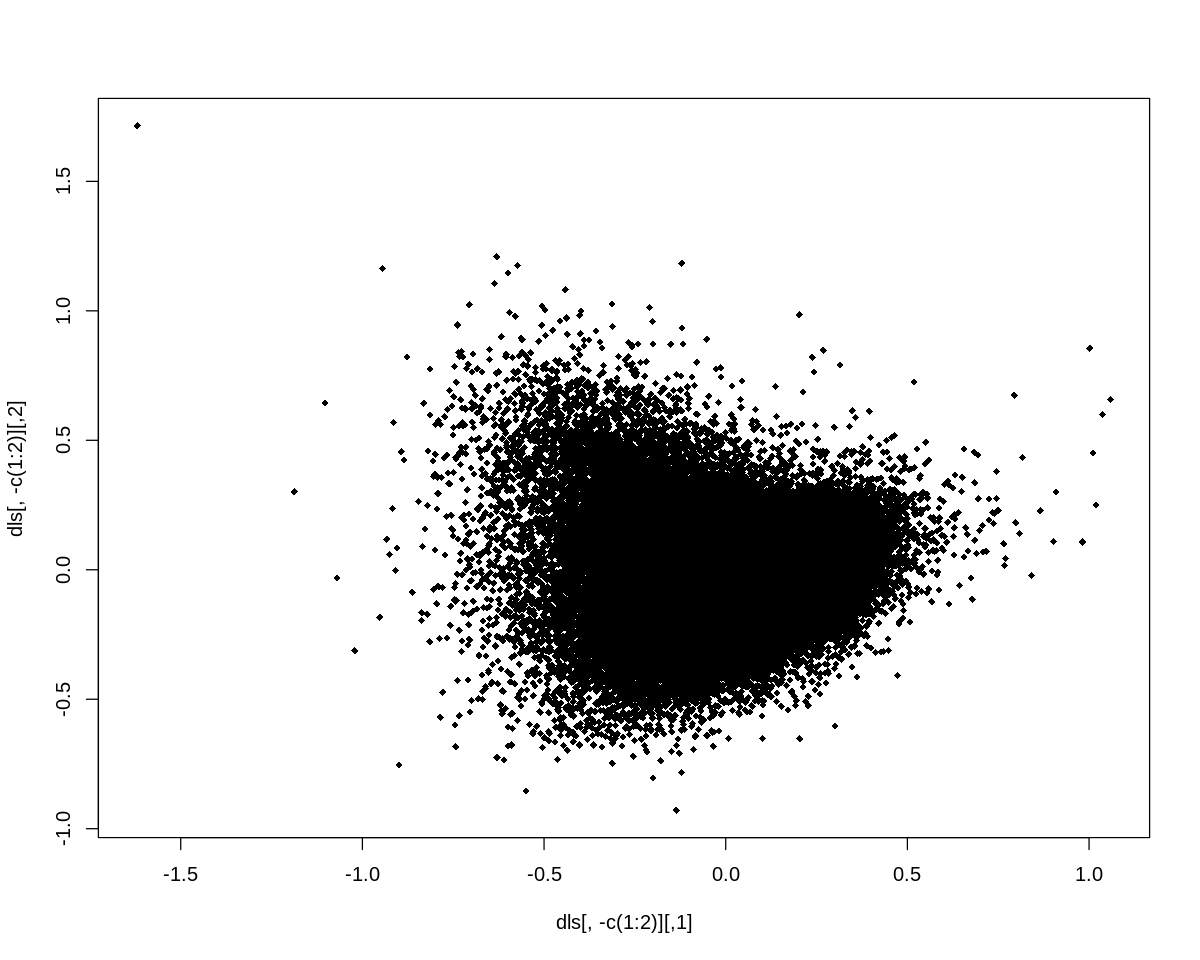

In [ ]:
# Graph of docs using 2° and 3° latent dimensions
plot(dls[,-c(1:2)], pch=18, cex=0.8)

As you can see, the documents are now distributed almost in a circle.

## Analysis of song genres

In [14]:
install.packages('dplyr', quiet=T)
library('dplyr')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Let's print the most represented genres and check how many elements we have for the first 10 genres.

In [15]:
genres <- songs_df$tag

genre_10 <- summary(as.factor(genres))[1:10]
cat(paste(names(genre_10), genre_10, sep=":", collapse='\n'))

rock:13379
pop:5763
indie:5584
country:4078
punk:3512
soul:2507
folk:2472
80s:2316
classic rock:2064
alternative:1924

In [ ]:
cat("The", genre_10['rock']*100/length(genres),"% of songs are rock.")

The 8.853874 % of songs are rock.

The total number of genres is 100 but for the purpose of the project, I restricted them to the top 10 and I created a color mapping for these ones in order to make a plot.

In [16]:
# Take only the songs that are among the top 10 genres
top_genre_rows <- genres %in% names(genre_10)

# Creates color mapping to plot the genres
color_mapping <- recode(genres, rock="red", pop="blue", indie="green", country="burlywood4",
                        punk="blueviolet", soul="aquamarine", folk="deeppink", "80s"="chartreuse",
                        "classic rock"="darkgoldenrod1", alternative="deepskyblue", .default='black')

In the following cell I keep only the elements from the genre list that belong to one of the top 10 music styles.

In [17]:
# Conversion of the class names to colors in order to distinguish in the graph the genre of the songs.
genre_colors = as.vector(color_mapping)[top_genre_rows]

head(genre_colors[1:10])
head(genres[top_genre_rows][1:10])

[1] "chartreuse"     "darkgoldenrod1" "green"          "green"         
[5] "green"          "red"

[1] "80s"          "classic rock" "indie"        "indie"        "indie"       
[6] "rock"

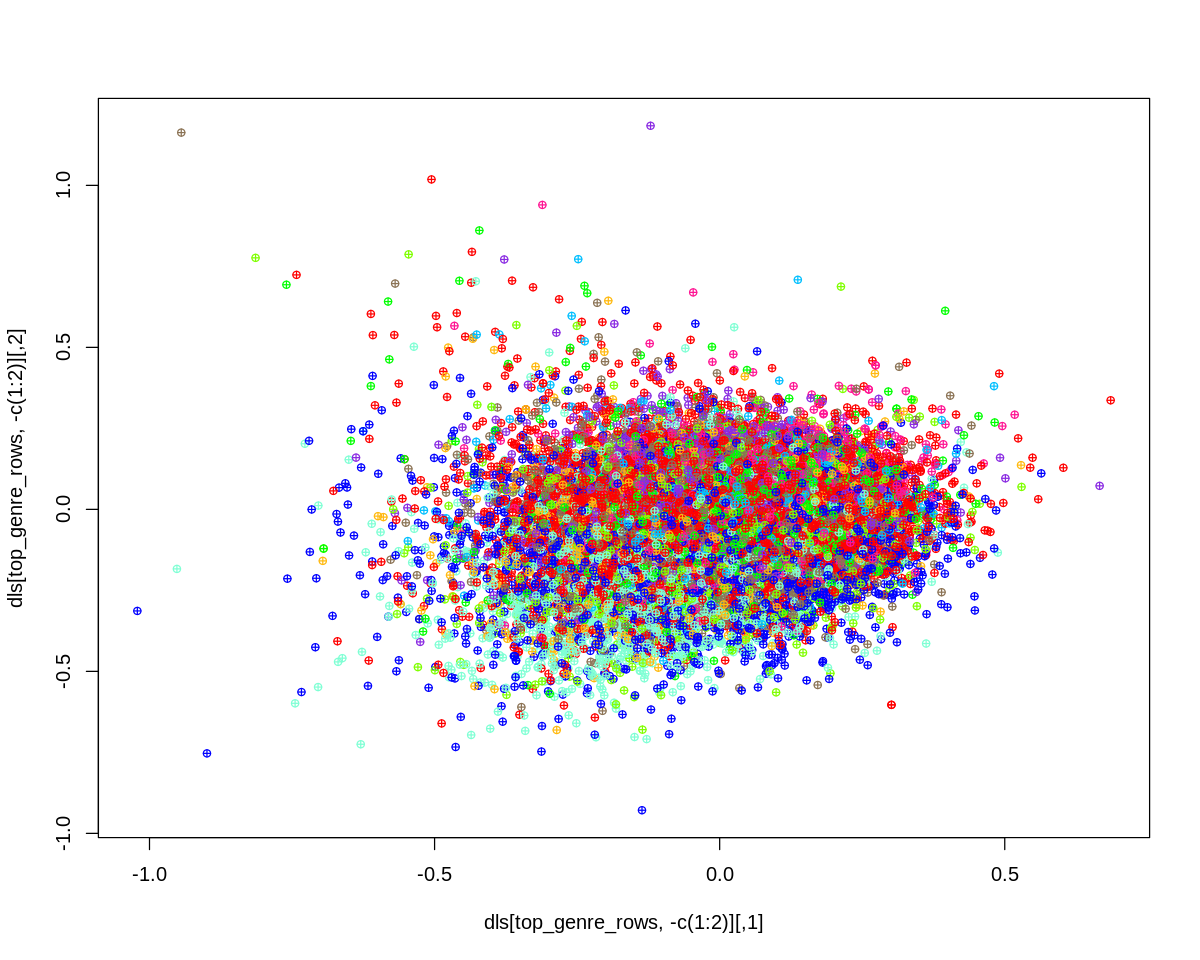

In [ ]:
# Let's plot only the top genres to better understand the distribution removing noise
options(repr.plot.width=10, repr.plot.height=8)
plot(dls[top_genre_rows, -c(1:2)], pch=10, cex=0.8, col=genre_colors)

We cannot deduct a lot of information from the graph, probably because in songs of different genres the artists can still use similar words and only change the melody. Moreover, we have a lot of rock and pop songs, therefore it's more likely to find a lot of different words for those genres than for the others. 

Let's try to restrict the analysis to four genres that can be considered quite interesting, soul songs are different from classic rock ones and classic rock songs may have some similarities with country music. Alternative is basically different from others but with some common points.

In [18]:
# Take some different genres
genre_4_rows <- genres %in% c('soul', 'country', 'classic rock', 'alternative')

genre_4_colors = as.vector(color_mapping)[genre_4_rows]

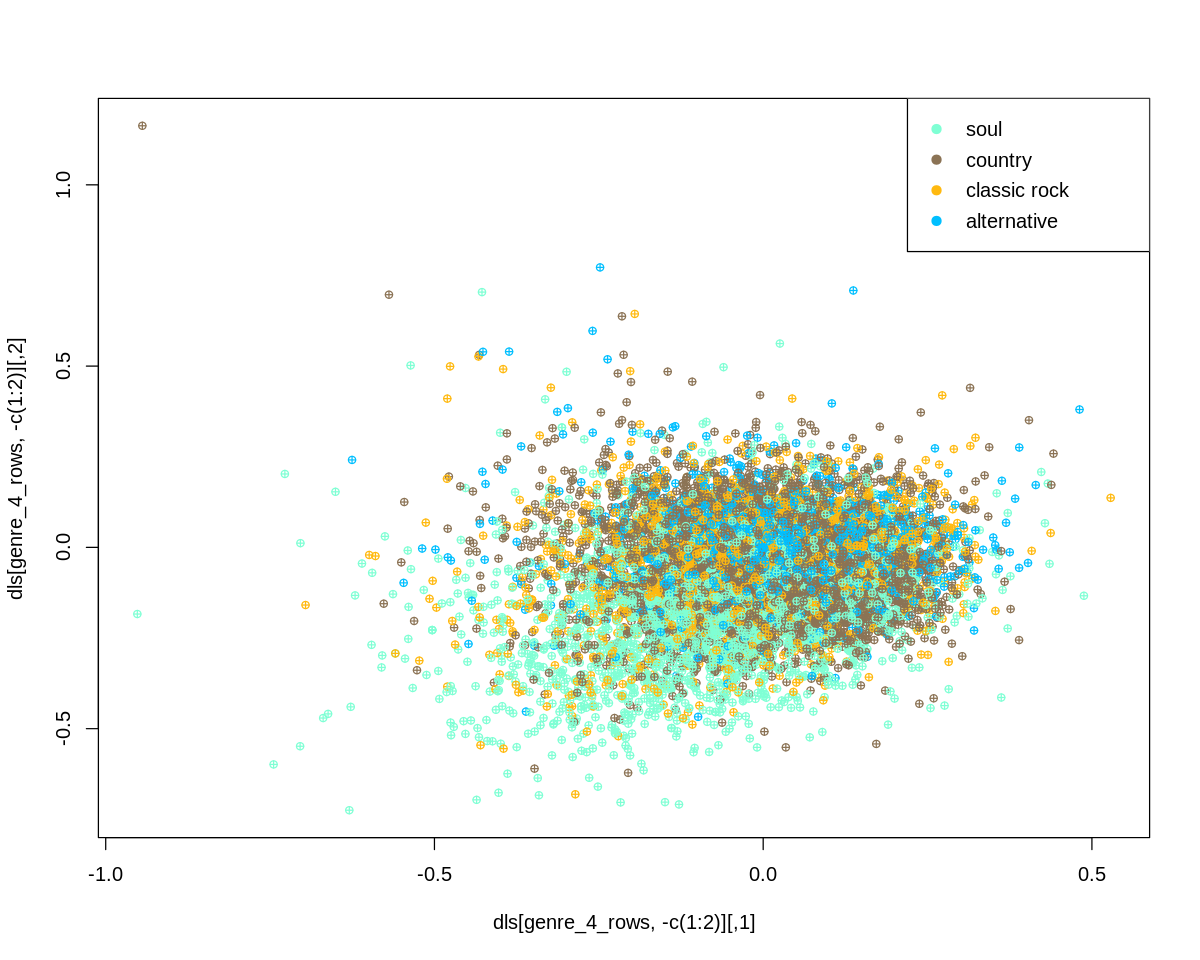

In [ ]:
# Let's plot only some genres to better understand the distribution
options(repr.plot.width=10, repr.plot.height=8)
plot(dls[genre_4_rows, -c(1:2)], pch=10, cex=0.8, col=genre_4_colors)
legend(x="topright", legend=c("soul", "country", "classic rock", 'alternative'), col=c("aquamarine", "burlywood4", "darkgoldenrod1","deepskyblue"), pch=19) 

As you can see the soul is quite expanded in the bottom part of the graph, while classic rock and country, that are related genres, are more compacted. 

In [19]:
# Retrieve only top 135 words, considering the norm, to avoid confusion in the graph
top_terms <- names(sort(norm_terms_lsa, decreasing=T)[1:135])
top_terms_rows <- rownames(tls) %in% top_terms

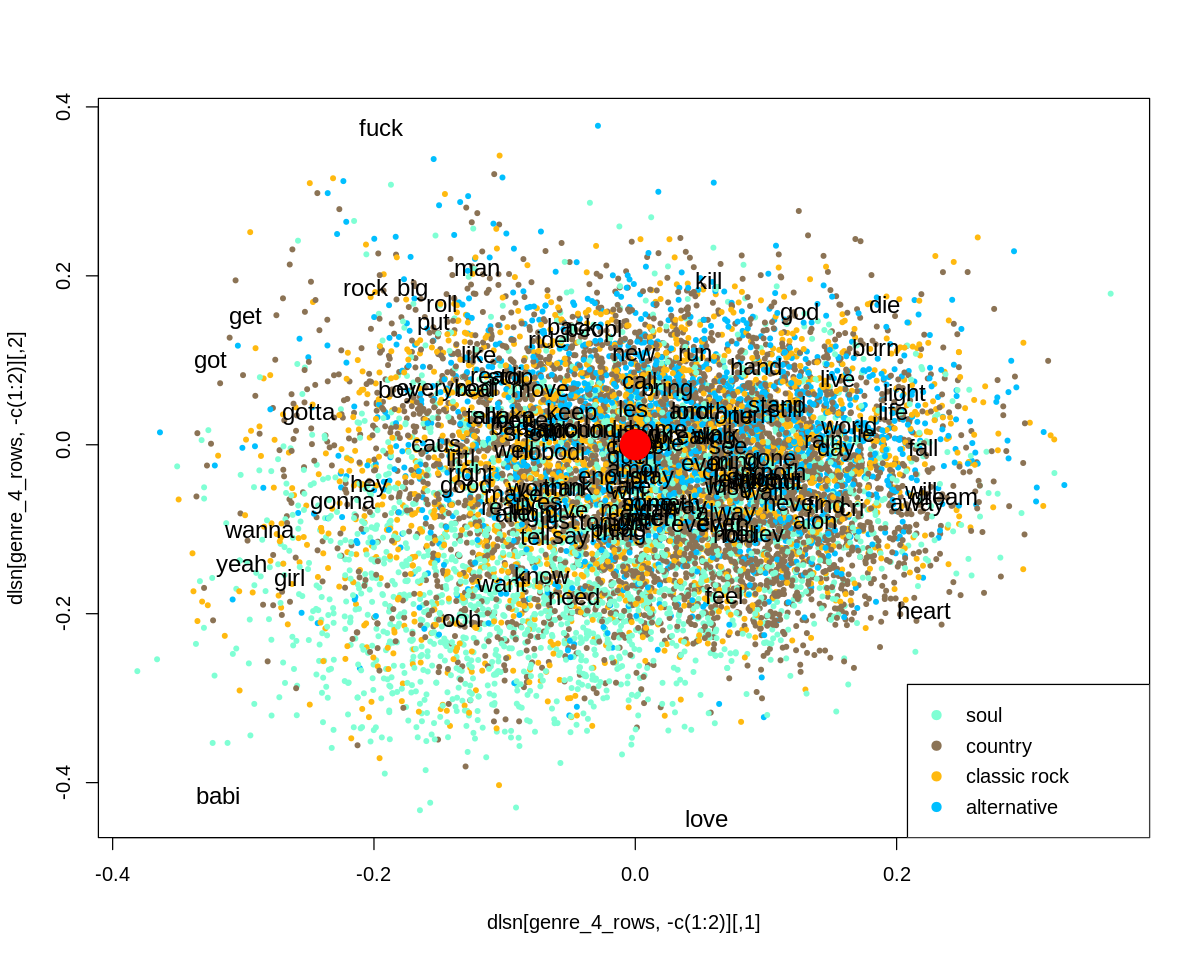

In [20]:
# Definition and application of the function for the normalization of terms and docs vectors 
# indeed the vectors tls and dls are not normal because achieved by the product with sk
norm_rows <- function(x) x / apply(x, 1, norm, "2")
tlsn <- norm_rows(tls)
dlsn <- norm_rows(dls)

# New graph with normalized vectors of terms and docs
options(repr.plot.width=10, repr.plot.height=8)
plot(dlsn[genre_4_rows,-c(1:2)], pch=20, cex=0.8, col=genre_4_colors)
text(tlsn[top_terms_rows,-c(1:2)], labels=words[top_terms_rows], cex=1.2)
points(0, 0, pch=20, cex=5, col="red")
legend(x="bottomright", legend=c("soul", "country", "classic rock", 'alternative'), col=c("aquamarine", "burlywood4", "darkgoldenrod1","deepskyblue"), pch=19) 

If we would have embeddings of documents and words and we would cut the vectors to have 2 dimensions and to represent them in a graph, it would not be guaranteed to capture most of relevant information, we would simply look at a specific projection (keeping the first 2 rows for example). The distribution that we are showing may be wrong with respect to the real distribution. 

Using our approach, we are sure that the first dimensions capture much more information than the others, therefore the problem is less relevant.

At this point, I want to check if there is a correlation between a characteristic word of the 'classic rock' with songs of this genre.

## Chi-square tests to observe correlation between some words and some genres

I decided to test the term 'rock', that should be quite useful to give us some information about the songs. Let's verify objectively if exits a lexical correlation between the term and some genres in the original space tdm, i.e. not-lsa.

In this case, I consider only the docs containing the term and I do the analysis using the chi-square test.

In [21]:
# We compute the contingency matrix
rock_cr <- table(tdm["rock",] > 0, genres=="classic rock")

dimnames(rock_cr) <- list(rock=c("No", "Yes"), "classic rock"=c("No", "Yes"))
# This function computes automatically the expected frequencies (i.e. theoretical) 
# from the observed ones. We don't need to correct because we don't have small values.
chisq_test_cr = chisq.test(rock_cr, correct=FALSE) 

# chi-square distribution is simply the summation of several squared variables and
# they are normally distributed (this is the theoretical squared distribution).
chisq_test_cr


	Pearson's Chi-squared test

data:  rock_cr
X-squared = 19.148, df = 1, p-value = 1.209e-05


In [ ]:
# Expected values and observed values from the chisquare test 
chisq_test_cr$expected
chisq_test_cr$observed

,No,Yes
No,142920.809,1979.19118
Yes,6124.191,84.80882


     classic rock
rock      No    Yes
  No  142960   1940
  Yes   6085    124

As you can see, the term is very correlated to the genre considering the original matrix. Just from the deviation between the expected and the observed values for "Yes"-"Yes" you may expect a high chi-square and a small p-value. 

To show another example, the p-value for the term 'rock', considering the 'alternative' genre is very high.

In [22]:
# We compute the contingency matrix
rock_al <- table(tdm["rock",] > 0, genres=="alternative")

dimnames(rock_al) <- list(rock=c("No", "Yes"), alternative=c("No", "Yes"))

chisq_test_al = chisq.test(rock_al, correct=FALSE) 
chisq_test_al


	Pearson's Chi-squared test

data:  rock_al
X-squared = 1.3512, df = 1, p-value = 0.2451



In order to refine the query, to get a more precise hint about the correlation between the term and the genre, you can first check which are the most similar terms to 'rock' and then perform the Chi-squared test again.

### Expand the query with semantically related terms

As said in the previous cell, I cannot conclude that a relation exists between the term and the genre simply considering that test. Therefore, I add a semantically similar term to the query in order to have a better intuition about the relationship. 

In [24]:
# Find the semantically closest terms to rock in the LSA space
similar5 <- associate(tls[,3:4], "rock", threshold=0.8)[1:5]
cat("The 5 most similar terms to 'rock':\n", names(similar5))

# Check the norm
tmp_norm <- sort(norm_terms_lsa, decreasing=T)
cat("\n\nThe value of the norm for", names(similar5))
data.frame(tmp_norm, row.names=names(tmp_norm))[names(similar5),]

The 5 most similar terms to 'rock':
 quit like move put money

The value of the norm for quit like move put money

[1]  4.270168 35.579526 27.781040 25.956115 24.949908

Given that all these 5 words were very similar, but the norms are quite different, I take the word with the highest norm that is 'like'.

In [25]:
# Let's verify if also the couple "rock like" is objectively correlated to the classic rock genre
rock_like_cr <- table(tdm["rock",]>0 & tdm["like",]>0, genres=="classic rock")
dimnames(rock_like_cr) <- list("rock like"= c("No", "Yes"), "classic rock"=c("No", "Yes"))
chisqtest = chisq.test(rock_like_cr, correct=FALSE)

chisqtest


	Pearson's Chi-squared test

data:  rock_like_cr
X-squared = 0.59105, df = 1, p-value = 0.442


You can see that the p-value is very high and this may be due to the fact that 'like' is a very common term and not much related to the genre 'classic rock' or to the term 'rock'.

But if I consider the most similar terms computed on the second and third latent dimensions I get different words, among which there is an interesting one: 'roll'. 

In [26]:
# Find the semantically closest terms to rock in the LSA space
similar5 <- associate(tls[,2:3], "rock", threshold=0.8)[1:5]
cat("The 5 most similar terms to 'rock':\n", names(similar5))

# Check the norm
tmp_norm <- sort(norm_terms_lsa, decreasing=T)
cat("\n\nThe value of the norm for", names(similar5))
data.frame(tmp_norm, row.names=names(tmp_norm))[names(similar5),]

The 5 most similar terms to 'rock':
 gun hey drink roll brother

The value of the norm for gun hey drink roll brother

[1] 11.404047 38.101341  8.075535 25.544312 10.256953

In [27]:
# Let's verify if the couple "rock roll" is correlated to the classic rock genre
rock_roll_cr <- table(tdm["rock",]>0 & tdm["roll",]>0, genres=="classic rock")
dimnames(rock_roll_cr) <- list("rock roll"= c("No", "Yes"), "classic rock"=c("No", "Yes"))
chisqtest = chisq.test(rock_roll_cr, correct=FALSE)

chisqtest


	Pearson's Chi-squared test

data:  rock_roll_cr
X-squared = 65.545, df = 1, p-value = 5.68e-16


As easily understandable, the p-value in this case is very very low, this means that the query 'rock roll' is strongly correlated to the genre 'classic rock'.

### Use LSA to capture semantic meaning

Up to now, I am basing my analysis on lexical matching, let's try to exploit LSA in order to capture semantic meaning. We want to see if there is a semantic correlation between the couple of terms and the genre.

In [28]:
# To peform this analysis let's transform the query "rock like" in a doc and do the fold_in in the LSA space
rock_like_query <- "rock like"
rock_like_vec <- query(rock_like_query, words)
rock_like_le <- lw_logtf(rock_like_vec) * (1-entropy(tdm))
rock_like_ls <- t(rock_like_le) %*% lsar$tk
rock_like_ls

ROCK LIKE,-0.02136865,0.001290598,-0.03037044,0.02999649,-0.02603324,0.007698224,-0.003407139,-0.007162968,-0.02828541,0.03285083,⋯,0.002264033,-0.009841946,-0.003769397,0.04281337,-0.01537592,-0.001538599,-0.01347996,-0.01441581,-0.01496074,-0.007530897


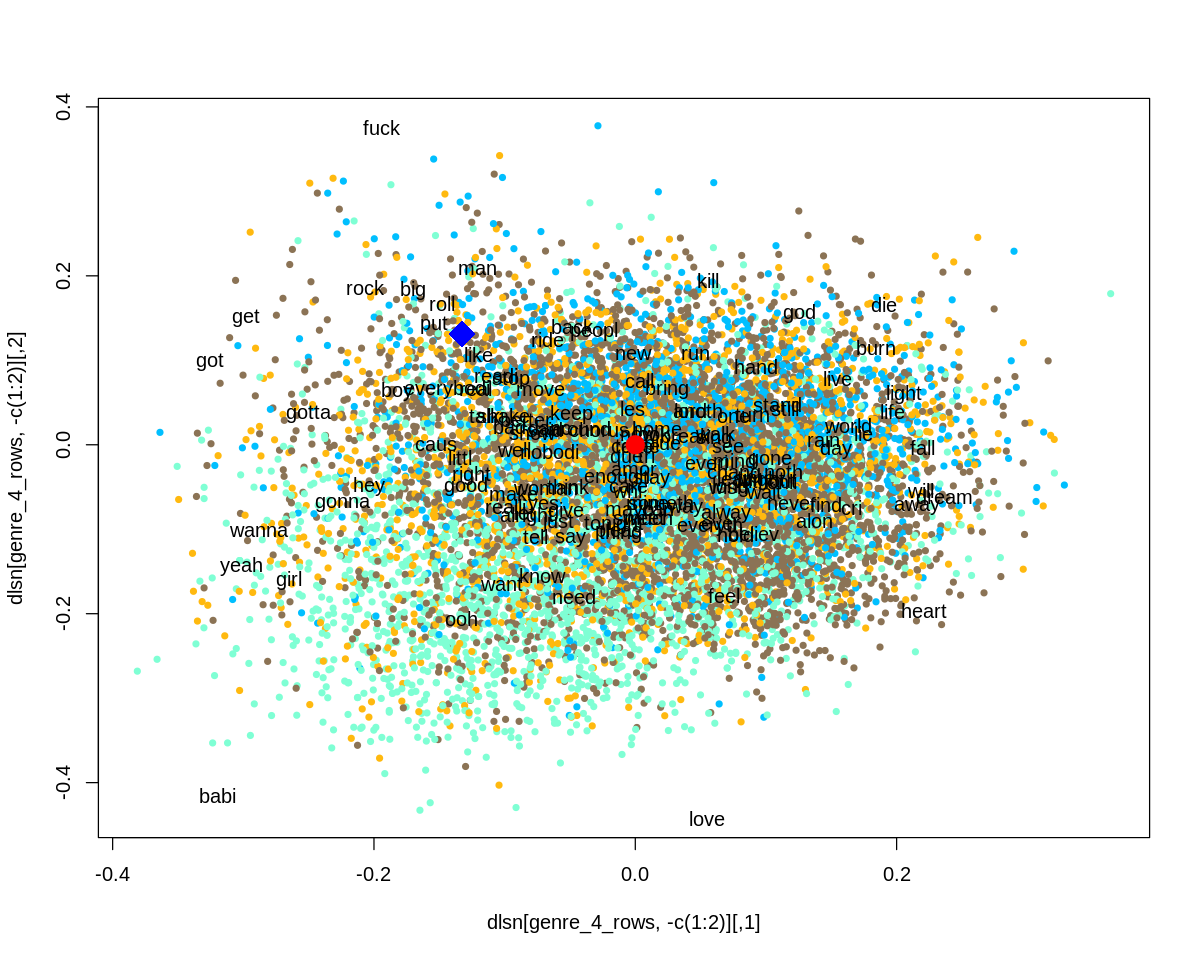

In [29]:
# Graph of the terms, docs and query in the LSA space using the dimensions 3 and 4
plot(dlsn[genre_4_rows,-c(1:2)], pch=20, cex=1, col=genre_4_colors)
text(tlsn[top_terms_rows,-c(1:2)], labels=words[top_terms_rows], cex=1)
points( 0, 0, pch=20, cex=3, col="red") 

rock_like_ls_n <- norm_rows(rock_like_ls)
points(rock_like_ls_n[3], rock_like_ls_n[4], cex=3, pch=18, col="blue")

In [30]:
# Define the function that returns a vector of cosine similarities between vector Q and the rows of matrix X
cosines <- function(X, Q) apply(X, 1, cosine, as.vector(Q))

# Function that returns the indices of the N higher values in X 
top <- function(X, N) order(X, decreasing=TRUE)[1:N]

Now I can use these functions to compute the most similar songs to a given input, the query 'rock like' in this case.

In [31]:
# Top 10 songs that are more semantically similar to the query, considering only 3° and 4° latent dimensions
sim_10_songs <- top(cosines(dls[,3:4], rock_like_ls[3:4]), 10)

# List the 10 songs
songs_df[sim_10_songs, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
144932,What's Goin' On,Quincy Jones,soul
38392,Immortelle,Lara Fabian,french
137535,Far Beyond Metal,Strapping Young Lad,metal
126872,Run Away,The Leftovers,pop punk
93019,Mention,Apache Indian,ragga
87943,I Don't Like You,Roger Miret & The Disasters,punk
105501,Get Ignit,Westside Connection,West Coast Rap
127282,Front Street (Album),Gutter Twins,alternative
140407,Steady Beat Convention,Chris Murray,ska


As you can see the majority of the similar songs are not actually related to the 'classic rock' genre, while if we computed the cosine similarities for the query 'rock roll' we get rock songs, actually not of the genre 'classic rock' but they belong to different types of rock related to 'classic rock'. 

In [32]:
rock_roll_query <- "rock roll"
rock_roll_vec <- query(rock_roll_query, words)
rock_roll_le <- lw_logtf(rock_roll_vec) * (1-entropy(tdm))
rock_roll_ls <- t(rock_roll_le) %*% lsar$tk
rock_roll_ls

ROCK ROLL,-0.01745285,0.002229931,-0.03795007,0.04089622,-0.0411317,0.01154073,-0.001775568,-0.01910866,-0.02719035,0.03467789,⋯,0.004969087,0.0003068411,0.004787242,-0.02450871,0.001463215,-0.005282794,0.01260044,0.0008992995,0.01044711,0.005258477


In [33]:
# Top 10 songs that are more semantically similar to the query, considering only 3° and 4° latent dimensions
sim_10_songs_rr <- top(cosines(dls[,3:4], rock_roll_ls[3:4] ), 10)

# List the 10 songs
songs_df[sim_10_songs_rr, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
110596,Ain't Nobody Here But Us Chickens,LOUIS JORDAN,swing
59119,Live It Up,Danger Danger,hair metal
4748,Run A Mile,The Pineapple Thief,rock
3263,Let It Roll,Velvet Revolver,hard rock
140292,Let It Roll,The Charlie Daniels Band,Southern Rock
143116,Coeur De Glace,Naast,rock
77632,Better Than This,Jonah Matranga,alternative rock
140181,She Ain't Afraid,Twiztid,psychopathic
33935,We Are The Boys,Pulp,glam


To avoid the loss of information you can choose a latent space with more dimensions. I want to detect the knee points in the curvation function of the eigenvalues distribution. A knee point is a local minimum of the curvation radius of the iperbole function interpolating the data. 

I tried to take more dimensions to check if I would have get better results for the 'rock like' query.

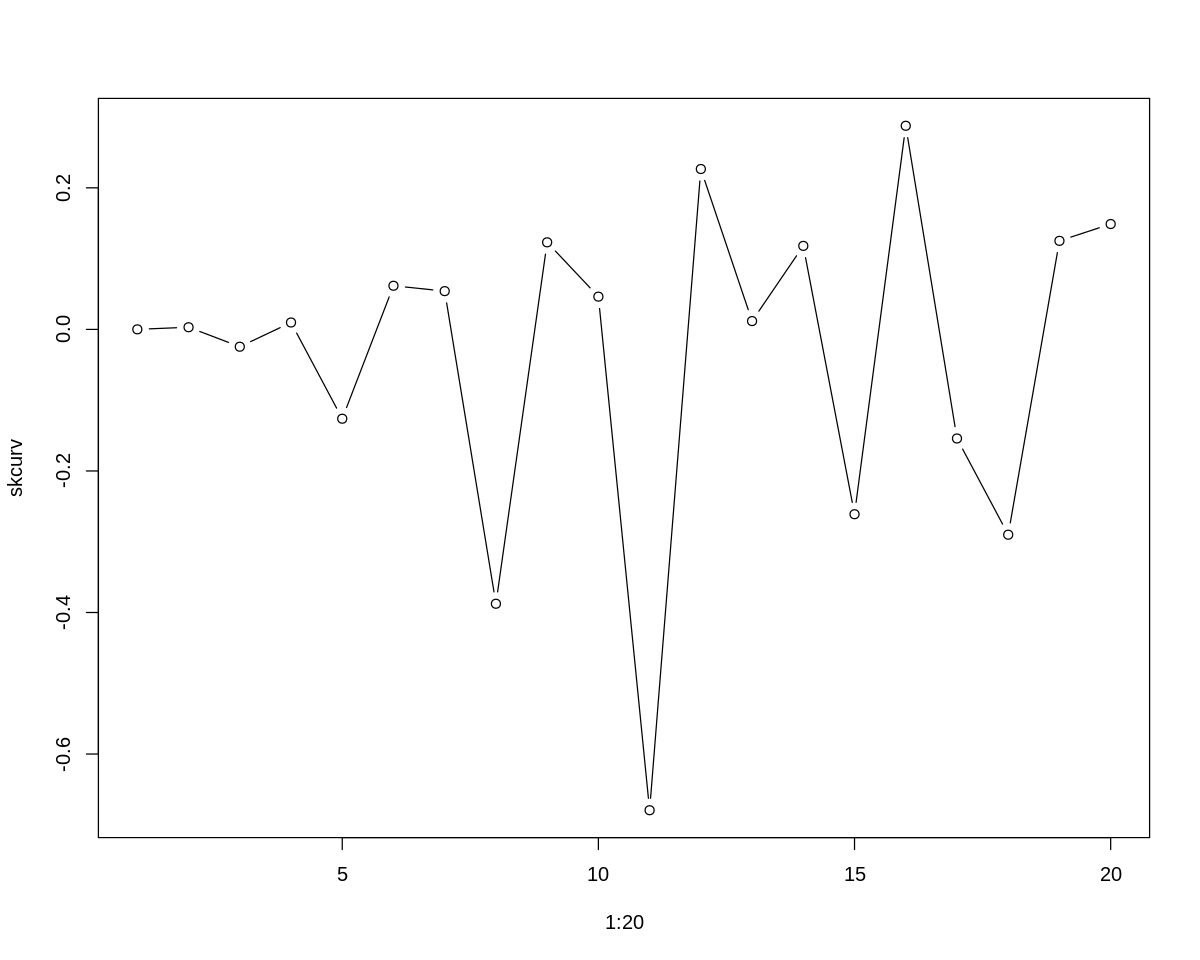

In [34]:
fordiff <- function(x) x[2:length(x)] - x[1:(length(x)-1)]
skd <- fordiff(lsar$sk)
skdd <- fordiff(skd)
skcurv <- skdd[1:20] / (1+(skd[1:20])^2)^1.5
plot(1:20, skcurv, type="b")

I test the first local minimum that is 5, so I take the first 5 latent dimensions.

In [35]:
sim_5_dim <- top(cosines(dls[,1:5], rock_like_ls[1:5]), 10)

# List the 10 songs
songs_df[sim_5_dim, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
138759,Patrik och Lillen - Vifta med händerna (short basshunter remix),Basshunter,trance
36102,Chant Of The Ever Circling Skeletal Family (1999 Digital Remaster),David Bowie,rock
84391,Dödsorganism,Obligatorisk Tortyr,grindcore
118821,Hello There,Cheap Trick,classic rock
111942,Upbeat,Micha Moor,funky
76330,Rock a Nevem,Tankcsapda,magyar rock
133147,Rock A Nevem,Tankcsapda,magyar rock
88254,Jingle Bell Rock,Chet Atkins,christmas
34079,Rock N Roll McDonalds,Wesley Willis,rock


The results are much better increasing the information quantity and there are rock songs between the most similar to the query. But this is a qualitative analysis, let's compute the chi-squared test to test if there is a correlation between 'rock like' and 'classic rock' genre within the latent space.

TODO: studia R-precision riguardando anche video di Moro magari e guarda anche knee point.

In [37]:
# We need to fix the maximum number of returned results (R-precision), this number
# is given by the number of 'classic rock' songs within the entire dataset.
# Compute the distribution of the genre in the first k results of the search with k=10, 50, 100
table(genres[top(cosines(dls[, 1:5], rock_like_ls[1:5] ), 10)])
#table(genres)
# Give the possibility to retrieve all the 'classic rock' songs that are 2064
#table(genres[top(cosines(dls[, 1:5], rock_like_ls[1:5] ), 2064)])

rock_like_5_dim <- table(1:nrow(dls) %in% top(cosines(dls[,1:5], rock_like_ls[1:5]), 2064), genres=="classic rock" )
dimnames(rock_like_5_dim) <- list('rock like'=c("No", "Yes"), 'classic rock'=c("No", "Yes"))
rock_like_5_dim


   christmas classic rock        funky    grindcore  magyar rock         rock 
           1            1            1            1            2            3 
      trance 
           1 

         classic rock
rock like     No    Yes
      No  147029   2016
      Yes   2016     48

In [38]:
chisq.test(rock_like_5_dim, correct=FALSE)


	Pearson's Chi-squared test

data:  rock_like_5_dim
X-squared = 14.305, df = 1, p-value = 0.0001554


Considering the latent space, the probability that the terms 'rock like' and the genre 'classic rock' are not related is low.

## Songs recommendation

The next goal is to detect the most similar songs to a given input text in order to build a simple recommendation system based on song lyrics. As first thing I need to load on a dataframe the evaluation dataset that I already downloaded at the beginning of the notebook, it contains for each song a list of similar songs.

In [39]:
evaluation_df <- read.csv(dl_eval$local_path)
# Removing the lyrics to avoid ugly output in the cell
evaluation_df[1:3, names(evaluation_df) != "lyrics"]

,track_id,title,artist_name,tag,target
,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAADNN128F42B1D94,Bernadette,Arrah and the Ferns,indie pop,"TRRPVJB12903CC656D,TRLNMXB128F147C8E8,TRQRSIH128E0799076,TRCCKFR128F4292375,TRTPLVO128F4260CB3,TRUOKCU128F14882DE,TRPOBNN128F933BFE0,TRXAYVD128F4244364,TRPRFAL12903CAF1D2,TROYDZH128F42B1D92,TRPCUYC128F4276FFE,TRYPSTC128F42B1D91,TRXEMOI12903CFEAF2,TRCPDQN128F14882DA,TRHRYOA128F425739B,TRLPFOC128F932AB0F,TRFGLDA128F932AB11,TRWFQJK128F9329426,TROAEJG128F92FB92C,TRRDIKR128F9330FC5"
2,TRAAGVM128E0784D95,Hourglass,Borialis,Look them up,"TRGVCAG128F934EE71,TRDJKGH12903CAA3C2,TRSJQUJ128F934EE7A,TRHAUXA128EF34A040,TRHMVQI128F425CF04,TRQMHZQ12903CF5E0B,TREWKOH128F148C457,TRHNONL12903CEC0C3,TRJRYEE128F429D81B,TRTMUVY12903D0752B,TREQCQK128F930727C,TRVCPQS128F426B0CC,TREIJGP12903CF5E09,TRDWYIB128F92CFF9D,TRPKWLQ128F92C2AA6"
3,TRAAPFE12903CF5DF4,Further,Cult Of Luna,Post-Metal,"TRHQFDE12903CF5DF2,TRDRIXM128F9314691,TRBHNKE12903CF5DC5,TRNCLWF12903CB45A0,TRNTOXI12903CDDD4A,TRQMZYF12903CDDD4D,TRSVNKP128F428CB99,TRTTCNW12903CDDD64,TRVWYRD128F930C0A3,TRXSLHW128F4290FF7,TRWVKLU128F92F179B,TRAKMKJ12903CF5DB9,TRMLXJP12903CF5DEF,TRESFMB128F4291A7B,TRGQUDO128F428CEA5,TRMVNED128F42911FB,TRQMPYE128F9314658"


In [ ]:
cat("The evaluation dataframe contains", nrow(evaluation_df), "songs.")

The evaluation dataframe contains 2517 songs.


Then I implemented some functions to simplify the next tests. The first function is used to create the vector in the LSA space given a song id. It retrieves the lyrics of that song from the dataframe and it creates the vector on them.

The second one is used to actually retrieve the n most similar songs, considering the desired latent dimensions and computing the cosine similarity between the given vector and the documents latent matrix.

In [224]:
create_lsa_vector <- function(song_id, df, words, tdm) {
    #' It returns the lsa vector of a song, given its name.
    #'
    #' @param song_name The string that represent the unique song id.
    #' @param df The dataframe from which the function retrieves the lyrics.
    #' @param words The list of words used to build the LSA space.
    #' @param tdm The document-term matrix to use for the operation.

    # If a dataframe is passed the function takes the lyrics from that
    if (inherits(df, "data.frame")){
        lyrics <- df[df$track_id == song_id, "lyrics"]
    }
    else{
        lyrics <- df
    }
    lyrics_vec <- query(lyrics, words)
    lyrics_le <- lw_logtf(lyrics_vec) * (1-entropy(tdm))
    lyrics_ls <- t(lyrics_le) %*% lsar$tk
    return(lyrics_ls)
}


compute_most_similar_songs <- function(dls, l_dim, df, song_vec, n) {
    #' It returns the dataframe with the most similar songs to the one given as
    #' input.
    #'
    #' @param dls The document-term matrix of the latent space.
    #' @param l_dim The latent dimensions to use for computing the cosine similarity. Passed as a list.
    #' @param df The dataframe from which the function will retrieve the information about the similar songs.
    #' @param song_vec The latent vector that represents the song for which we want similar ones.
    #' @param n The number of similar songs the function has to retrieve.

    sim_song_idx <- top(cosines(dls[, l_dim], song_vec[l_dim]), n)
    return(df[sim_song_idx, names(df) != 'lyrics'])
}

I also need to create a function that compare the track ids of the returned songs with the one of the actual similar ones. 

I import the Metrics package that allows to compute the mean average precision at k and I implemented a simple function that return the mAP@k given the vector of predictions and actual similar songs.

The average precision at k is the sum from AP@1 to AP@k of the precisions, divided by k. The mean of this value for each query submitted to the system is the average precision.

In [59]:
install.packages('Metrics', quiet=T)
library('Metrics')

In [301]:
compute_mAP_k <- function(k, target, predicted) {
    #' This function return the mAP@k for the 2 given vectors.
    #'
    #' @param predicted It's the vector of predicted track ids.
    #' @param target It's the vector of similar track ids.
    #' @param k Max length of predicted sequence.

    map_res <- mapk(k, target, predicted)
    return(map_res)
}


predict_row <- function(eval_data, songs_df, l_dim, k) {
    #' It creates the vector for the song, compute the most similar ones and returns them as string.
    #' 
    #' @param eval_data It's the list of data taken from one row of the evaluation dataframe.
    #' @param songs_df The dataframe of songs that the function gives as input to
    #'        'create_lsa_vector'.
    #' @param l_dim The latent dimensions to consider for the cosine similarity.
    track_id <- eval_data['track_id']

    song_vec <- create_lsa_vector(track_id, eval_data['lyrics'], words, tdm)
    predicted <- compute_most_similar_songs(dls, l_dim, songs_df, song_vec, k)
    return(paste(predicted$track_id, collapse=","))
}


In [314]:
# In order to create a column with NAs and then fill only the desired rows.
ciao['predictions'] <- NA
ciao[1:5, 'predictions'] <- apply(ciao[1:5,], 1, predict_row, songs_df=songs_df, l_dim=1:2, k=5)

In [ ]:
ciao[!names(ciao) %in% c('lyrics', 'target')]

In [233]:
#@title ##### Small example
song_id <- evaluation_df$track_id[255]

inp_song <- create_lsa_vector(song_id, evaluation_df, words, tdm)
pred_songs <- compute_most_similar_songs(dls, 1:11, songs_df, inp_song, 35)

In [297]:
predi <- predict_row(evaluation_df[255,], songs_df, 1:5, 35)

In [300]:
apk(10, strsplit(evaluation_df$target[255], split=",")[[1]], strsplit(a, split=",")[[1]])

[1] 0.4

In [179]:
# TODO: mostra che il minimo numero di canzoni simili per l'evaluation è 15, quindi facciamo map@15
prova <- strsplit(evaluation_df$target, ",")
ciao <- sapply(prova, length)